In [1]:
import torch
from toep_mlmm import Toep_MLMM1D
from dd_mlmm import DD_MLMM1D
import matplotlib.pyplot as plt

In [2]:
# 1d cases
def kfunc(X,eps=1e-5):
    x = X[:,0]
    y = X[:,1]
    return -torch.log((x-y).abs() + eps)
def kfunc_(x,eps=1e-5):
    return -torch.log(2*x.abs() + eps)
def ffunc(y):
    return 1-y**2

In [3]:
n = 7
m = 5
k = 1
device = torch.device('cpu')

In [4]:
dd_mg = DD_MLMM1D(n,m,k,device)
dd_mg.eval_ml_K(kfunc)

dd_mg.ml_grids[0].init_grid_hh()
hh = dd_mg.ml_grids[0].hh
nh = dd_mg.ml_grids[0].nh
Khh = kfunc(dd_mg.ml_grids[0].x_hh).reshape(nh, nh)
fh = ffunc(dd_mg.ml_grids[0].x_h).repeat(1,4)
u_ref = hh * (Khh @ fh)

In [5]:
toep_mg = Toep_MLMM1D(n,m,k,device)
toep_mg.eval_ml_K(kfunc_)
toep_mg.assemble_K()
u_toep = toep_mg.fft_kint(fh)

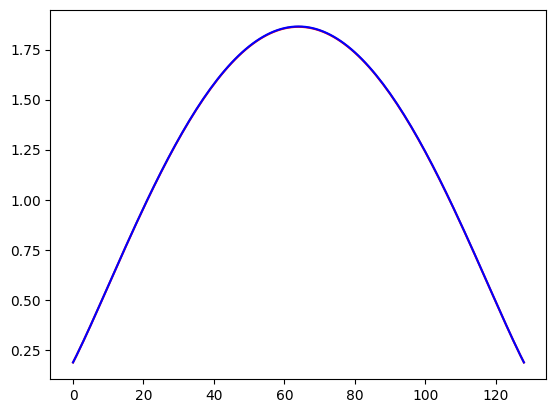

In [6]:
plt.plot(u_ref[:,0], '-r')
plt.plot(u_toep[:,0], '-b')

In [7]:
# 2d cases
def kfunc(X,eps=1e-5):
    x1 = X[:,0]
    y1 = X[:,1]
    x2 = X[:,2]
    y2 = X[:,3]

    K = ((x1-x2)**2 + (y1-y2)**2 + eps)**-0.5    
    return K

def kfunc_(X,eps=1e-5):
    x = X[:,[0]]
    y = X[:,[1]]
    return ((x)**2 + (y)**2 + eps)**-0.5    

def ffunc(X):
    x = X[:,[0]]
    y = X[:,[1]]
    u = 1 - (x**2+y**2)
    u = torch.nan_to_num(u, posinf=0)
    return u

In [8]:
from utils import matrl2_error

In [9]:
from toep_mlmm import Toep_MLMM2D
from dd_mlmm import DD_MLMM2D, DD_Grid2D

In [10]:
n = 7
m = 5
k = 1
device = torch.device('cpu')

In [11]:
# full
finest_grid = DD_Grid2D(2**n+1, m, device)
finest_grid.init_grid_hh()
hh = finest_grid.hh
nh = finest_grid.nh
Khh = kfunc(finest_grid.x_hh).reshape(nh*nh, nh*nh)
fh = ffunc(finest_grid.x_h).repeat(1,4)
u_ref = hh * (Khh @ fh)

In [12]:
# toep_mg 
toep_mg = Toep_MLMM2D(n,m,k,device)
toep_mg.eval_ml_K(kfunc_)
toep_mg.assemble_K()
u_toep = toep_mg.fft_kint(fh)

In [14]:
# dd_mg 
dd_mg = DD_MLMM2D(n,m,k,device)
nh = dd_mg.ml_grids[0].nh
dd_mg.restrict_ml_f(fh)
dd_mg.eval_ml_K(kfunc)

UnboundLocalError: local variable 'fh' referenced before assignment

In [28]:
print('toep_mg : {:.3e}'.format(matrl2_error(u_toep, u_ref).numpy()))

toep_mg : 5.712e-04


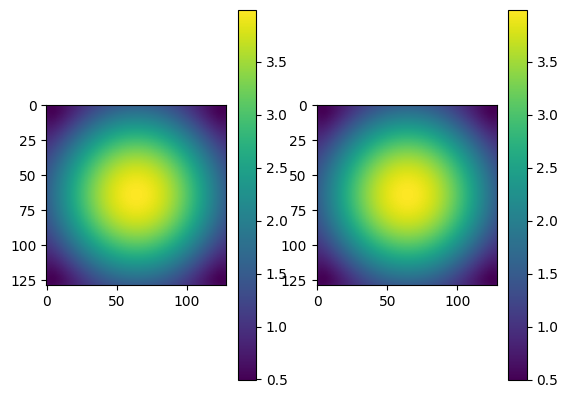

In [11]:
plt.subplot(121)
plt.imshow(u_toep[:,0].reshape(nh, nh))
plt.colorbar()
plt.subplot(122)
plt.imshow(u_ref[:,0].reshape(nh, nh))
plt.colorbar()
